# hw4 - NN pyTorch

Во всем задании вы должны работать со входом из строк размером (длиной) 1024

## Часть 1 Фурье

### Подготовка данных

Сгенерите данные (сигнал) любым пакетом для численного преобразования Фурье, [например](https://numpy.org/doc/stable/reference/generated/numpy.fft.fft.html#numpy.fft.fft)

In [3]:
import numpy as np
from matplotlib import pyplot as plt

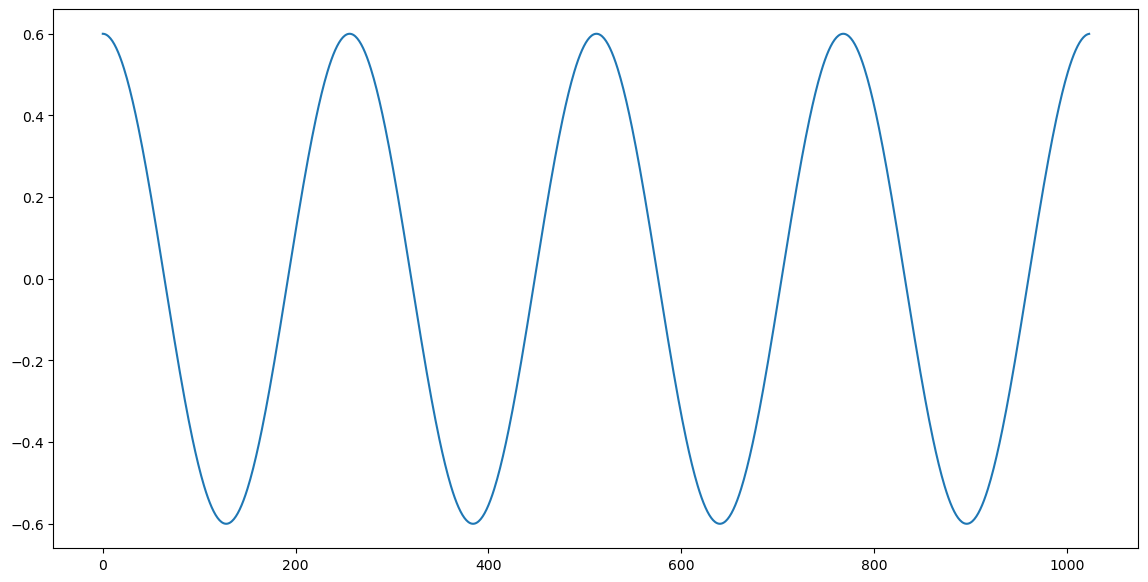

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def generate_wave(length):
    x = np.linspace(0, 1, length, endpoint=False)
    y = (0.6*np.cos(2 * np.pi * x *4))
    return y

x = np.linspace(0, 1, 1024, endpoint=False)

y = generate_wave(1024)
plt.figure(figsize=(14, 7))
plt.plot(y)

### Соберите и обучите нейросетку на pyTroch для преобразования Фурье

In [8]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from scipy.fft import fft, fftfreq
signals = np.array([generate_wave(1024) for _ in range(1024)])
yf = fft(signals)
xf = np.abs(yf)

X_train = torch.tensor(signals, dtype=torch.float32)
y_train = torch.tensor(xf, dtype=torch.float32)
dataset = TensorDataset(X_train, y_train)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

[[0.6        0.59981929 0.59927727 ... 0.59837427 0.59927727 0.59981929]
 [0.6        0.59981929 0.59927727 ... 0.59837427 0.59927727 0.59981929]
 [0.6        0.59981929 0.59927727 ... 0.59837427 0.59927727 0.59981929]
 ...
 [0.6        0.59981929 0.59927727 ... 0.59837427 0.59927727 0.59981929]
 [0.6        0.59981929 0.59927727 ... 0.59837427 0.59927727 0.59981929]
 [0.6        0.59981929 0.59927727 ... 0.59837427 0.59927727 0.59981929]]


In [22]:
class M(torch.nn.Module):
    def __init__(self, n):
        super(M, self).__init__()
        self.x = torch.nn.Sequential(
            torch.nn.Linear(n, n*2),
            torch.nn.Sigmoid(),
            torch.nn.ReLU(),
            torch.nn.Sigmoid(),
            torch.nn.Linear(n*2, n))

    def forward(self, x):
        x = self.x(x)
        return x

In [23]:
def mse_loss(input_, target):
    return (input_ - target).abs().square().mean()
loss_m=mse_loss

In [24]:
def train(model, optimizer, epoches, dataloader,loss_m, eps=1):
    loss_t=[]
    for epoch in range(epoches):
        for x,y in dataloader:
            prediction = model(x)
            loss = loss_m(prediction, y)
            optimizer.zero_grad()
            loss.backward(retain_graph=True)
            optimizer.step()
        loss_t = np.append(loss_t, loss.item())
        if loss < eps:
            break
    return loss_t

In [25]:
model = M(1024)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

In [26]:
t=train(model, optimizer, 300, dataloader, loss_m)

([<matplotlib.lines.Line2D at 0x1a2993881d0>], 0.9196748733520508)

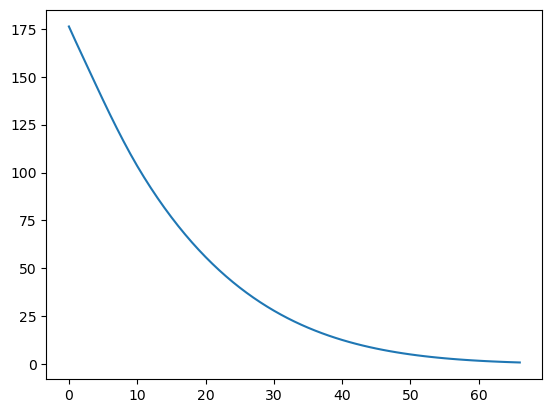

In [27]:
plt.plot(t), min(t)

### Сравните свое решение с пакетным методом

In [28]:
def mse_loss(x,y):
    return np.mean(np.square((x - y)))

signal = generate_wave(1024)
y=np.abs(fft(signal))
tensory = torch.tensor(signal, dtype=torch.float32).unsqueeze(0)
model.eval()
with torch.no_grad():
    x = model(tensory).squeeze().numpy()
print(mse_loss(x,y))

0.9128889316350106


## Часть 2 Power spectral density (dB)

### Подготовка данных

Используя пакетное решение, [например](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.periodogram.html), подготовьте обучающую выборку.

In [29]:
signals = np.array([generate_wave(1024) for _ in range(1024)])

In [30]:
import scipy
frequencies, psd = scipy.signal.periodogram(signal, 1024)

In [31]:
X_train = torch.tensor(signals, dtype=torch.float32).view(1, -1)
y_train = torch.tensor(psd, dtype=torch.float32).view(1, -1)
dataset = TensorDataset(X_train, y_train)
dataloader = DataLoader(dataset,batch_size=64, shuffle=True)

In [32]:
def train(model,optimizer,n_epochs,dataloader,loss_m):
    loss_t=[]
    for epoch in range(n_epochs):
        epoch_loss = 0
        for x, y in dataloader:
            optimizer.zero_grad()
            outputs = model(x)
            loss = loss_m(outputs, y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        loss_t.append(epoch_loss / len(dataloader))
    return(loss_t)

In [33]:
psd_db_outputs = np.array([scipy.signal.periodogram(sig, 1024)[1] for sig in signals])
X_train = torch.tensor(signals, dtype=torch.float32)
y_train = torch.tensor(psd_db_outputs, dtype=torch.float32)
dataset = TensorDataset(X_train, y_train)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)


class PSD(torch.nn.Module):
    def __init__(self):
        super(PSD, self).__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(1024, 1024*2),
            torch.nn.Sigmoid(),
            torch.nn.ReLU(),
            torch.nn.Sigmoid(),
            torch.nn.Linear(1024*2, 513))
    def forward(self, x):
        return self.net(x)


model = PSD()
loss_m = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=3e-3)
t=train(model, optimizer, 30, dataloader, loss_m)

([<matplotlib.lines.Line2D at 0x1a291bd6290>], 4.862977152621366e-16)

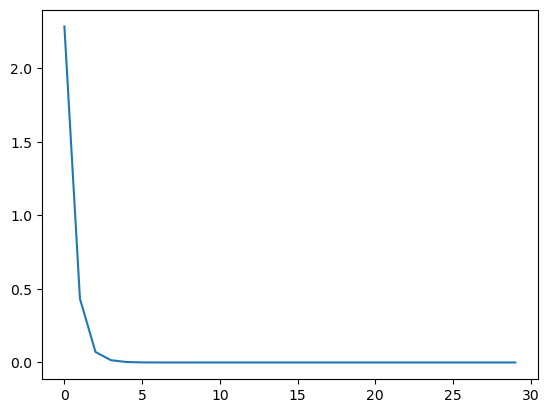

In [34]:
plt.plot(t), min(t)

### Соберите и обучите нейросеть для предсказания спектральной плотности мощности

*Подсказка: для входа 1024 выход будет 512*

### Провалидируйте свое решение

*Примечание: Для сдачи достаточно качественного соответствия по форме спектра с пакетным решением*

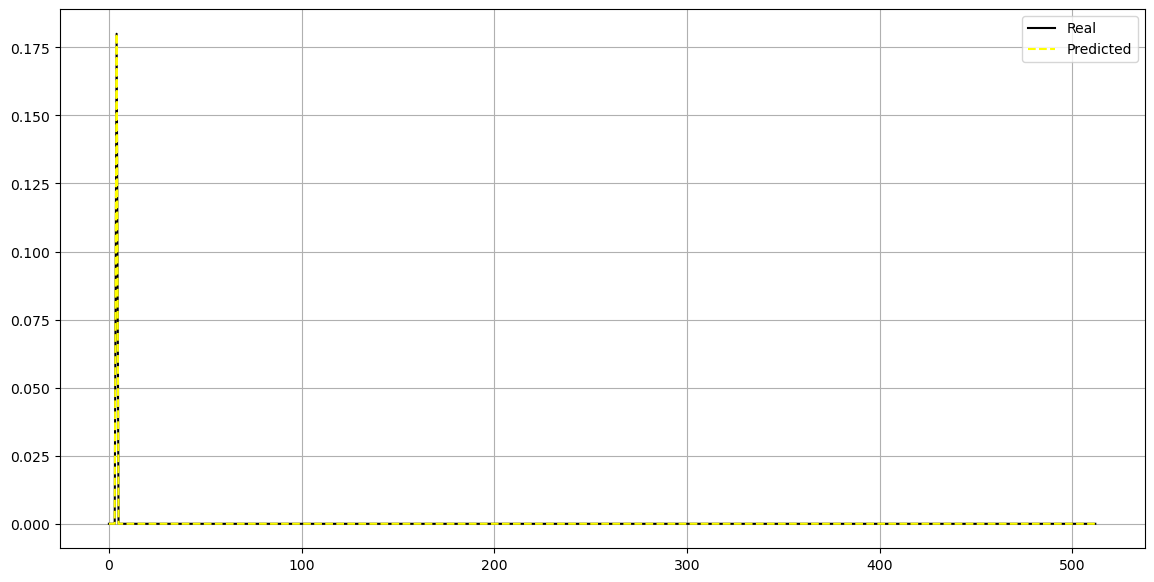

In [35]:
signal = generate_wave(1024)
frequencies, psd = scipy.signal.periodogram(signal, 1024)

signal = torch.tensor(signal, dtype=torch.float32).unsqueeze(0)
model.eval()
with torch.no_grad():
    pred = model(signal).squeeze().numpy()


plt.figure(figsize=(14, 7))
plt.plot(frequencies, psd, label="Real", color='black')
plt.plot(frequencies, pred, label="Predicted",linestyle='--', color='yellow')
plt.legend()
plt.grid()
plt.show()